Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 38.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.29MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.08MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/2], Loss: 0.09802831157462277
Epoch [2/2], Loss: 0.02270874634036163
Accuracy on adversarial examples: 19.724104549854793%


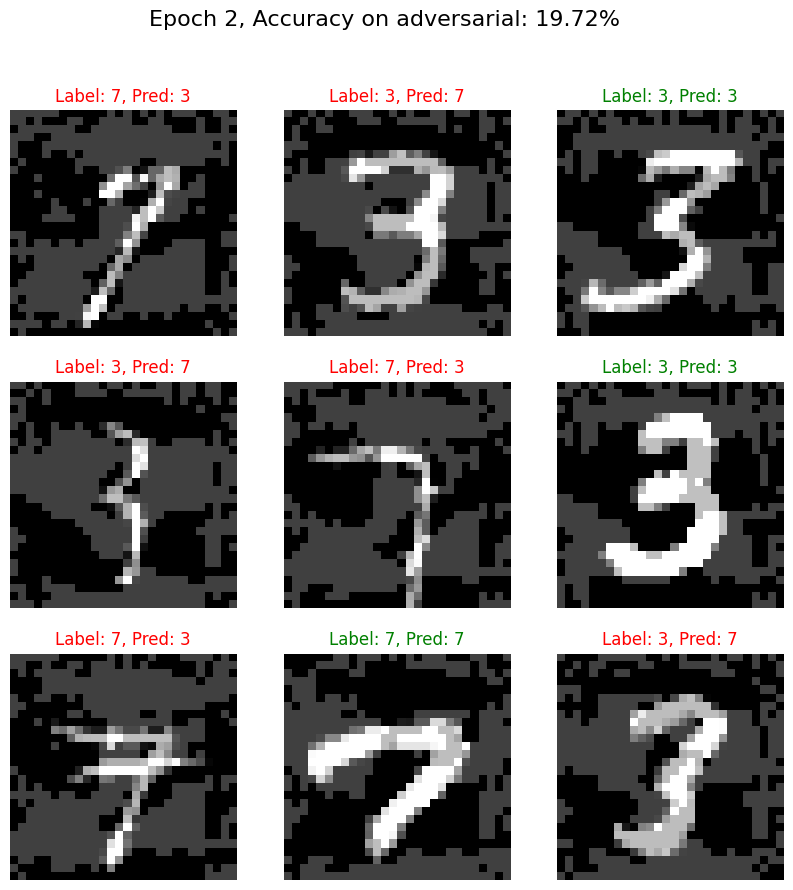

In [1]:
# @title Rnn deep avec epsilon = 0.25
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()



    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images

# Classe du modèle (réseau neuronal profond)
class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Charger les données MNIST (avec uniquement des 3 et des 7)
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


    indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] == 3 or full_dataset.targets[i] == 7]
    filtered_dataset = Subset(full_dataset, indices)

    train_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()

    correct = 0
    total = 0

    for images, labels in train_loader:

        images = images.clone().detach().requires_grad_(True)
        adversarial_images = FGSM(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')
    return accuracy

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 2  # Nombre d'époques d'entraînement

    train_loader = load_data()

    model = DeepNN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


RNN Deep mis face à une attaque adversariale, très peu performant lui aussi.